In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
from tqdm import tqdm
from collections import Counter
from scipy.spatial.distance import jensenshannon

In [3]:
lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

# Keys
ks = pd.read_csv(lda_path + 'keys.tsv',header=None,sep='\t', names = ['ix','s','words','label'])

# Dat
dat = pd.read_csv(lda_path + 'data.tsv',header=0,sep='\t',usecols=['topic_id','member-ref','party-ref','role','date','speaker','lemm_cleaned'])
dat['date'] = pd.to_datetime(dat.date,infer_datetime_format=True)
# dat['date'] = dat.date.apply(lambda x: pd.Timestamp(year=x.year,month = 1 if x.month // 6 == 0 else 6,day=1))

# Dists
dists = pd.read_csv(lda_path + 'dist.tsv',header=None,sep='\t').iloc[:,2:]
dists.columns = list(range(250))

# Metadata
# metadata = pd.read_csv('/home/rb/Documents/Data/metadata/metadata-full.tsv',sep='\t',parse_dates=['date'])
# metadata['date'] = metadata.date.apply(lambda d: pd.Timestamp(year=d.year,month=1 if d.month < 7 else 6,day=1))

# Date Dictionaries
# dates_topic = dict(zip(metadata.speech_id.str.split('.').str[4:6].str.join('.'), metadata.date))
# dates_speech = dict(zip(metadata.speech_id, metadata.date))

In [6]:
ks[ks.label.str.startswith('rhet/')]

,ix,s,words,label
1,1,0.03753,waardering groot bewindsman goed wijze woord w...,rhet/appreciation
9,9,0.04411,opmerking betoog punt woord ingaan spreker uit...,rhet/speech start
15,15,0.01927,politiek leven opvatting vrijheid mens beginse...,rhet/political principles
18,18,0.02724,verschil bestaan mening groot verschillend gaa...,rhet/difference of opinion
21,21,0.02325,gaan blijven jaar goed staan nieuw groot tijd ...,rhet/abstract
22,22,0.03310,begrip woord gebruiken term gaan duidelijk zin...,rhet/concepts and definitions
38,38,0.04711,discussie gaan voeren moment daarover orde vin...,rhet/discussions and debates
41,41,0.04321,vinden gaan feit zaak stelling volstrekt duide...,rhet/lines of reasoning
43,43,0.03536,regering bereid maatregel antwoord laten gaan ...,rhet/administrative intentions
44,44,0.03865,antwoord zaak bewindsman gaarne mogelijk aanzi...,rhet/government responses


In [8]:
dists.index = dat[['topic_id','date','member-ref','role']].astype(str).agg('_'.join,axis=1)
distsn = dists.groupby(dists.index).mean()

In [17]:
de = distsn.apply(entropy,axis=1)
de = de.reset_index(name='e')
de['index'] = pd.to_datetime(de['index'].str.split('_').str[1],format='%Y-%m-%d')

<Axes: xlabel='index', ylabel='e'>

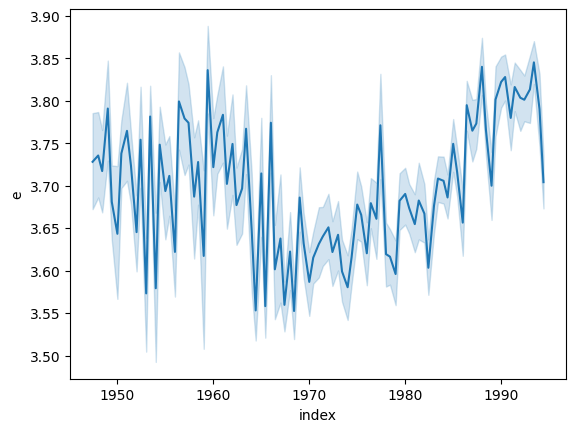

In [20]:
sns.lineplot(data=de,x='index',y='e')

# Text Length

In [23]:
dat['tl'] = dat.lemm_cleaned.str.split(' ').str.len()

<Axes: xlabel='date', ylabel='tl'>

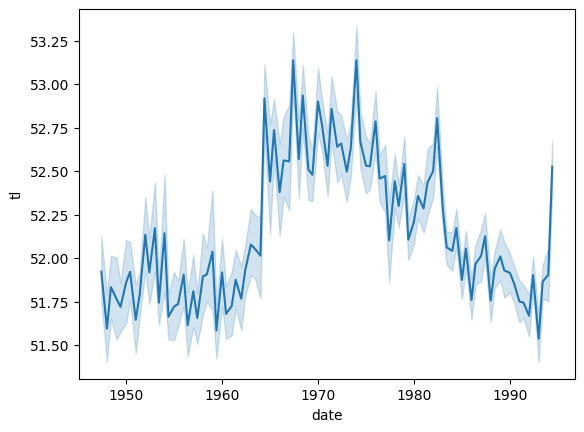

In [25]:
sns.lineplot(data=dat,x='date',y='tl')

## Rank 1 Proportions

In [28]:
de = distsn.max(axis=1)
de = de.reset_index(name='e')
de['index'] = pd.to_datetime(de['index'].str.split('_').str[1],format='%Y-%m-%d')

<Axes: xlabel='index', ylabel='e'>

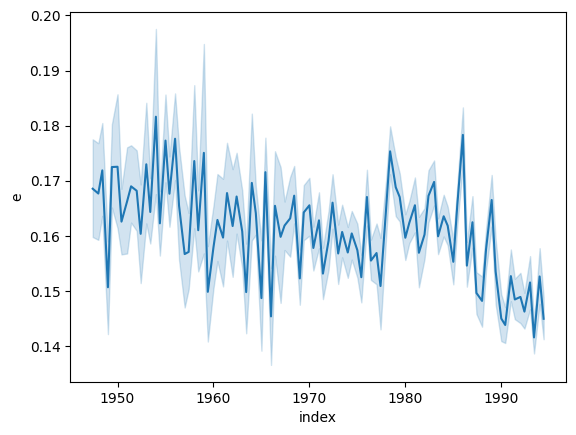

In [30]:
sns.lineplot(data=de,x='index',y='e')

In [ ]:
fig, ax = plt.subplots()

ax_ = ax.twinx()

sns.lineplot(data=maxt,x='date',y='maxp',ax=ax)
speech_length.plot(x='date',y='asl',ax=ax_,color='red')

In [ ]:
sld = pd.merge(maxt, metadata[['speech_id','text_len']], on='speech_id')

In [ ]:
sld['ns'] = (zscore(sld.maxp) / zscore(sld.text_len))
sns.lineplot(data=sld,x='date',y='ns')

## Entropy of Distributions

In [ ]:
edf = dists.apply(entropy,axis=1).reset_index(name='etp')
edf['date'] = edf.speech_id.map(dates_speech)

fig, ax = plt.subplots()

ax_ = ax.twinx()

sns.lineplot(data=edf,x='date',y='etp',ax=ax)
speech_length.plot(x='date',y='asl',ax=ax_,color='red')

In [ ]:
# Entropy Normalized

sld = pd.merge(edf, metadata[['speech_id','text_len']], on='speech_id')
sld['n_e'] = sld['etp'] / sld.text_len
sns.lineplot(data=sld,x='date',y='n_e')
sld['ns'] = (zscore(sld.etp) / zscore(sld.text_len))
sld.groupby('date').ns.mean().plot()

## Session Divergence

In [37]:
def get_dgs(a):
    n = a.shape[0]
    kld_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i != j:
                kld_matrix[i, j] = jensenshannon(a[i,:], a[j,:])
    return kld_matrix.mean(), kld_matrix.std()

In [32]:
distsn.index = distsn.index.str.split('_').str[0]

In [34]:
import random
from scipy.spatial.distance import jensenshannon

session_sample = set(random.sample(list(distsn.index.unique()),5000))

In [35]:
debate_groups = distsn[distsn.index.isin(session_sample)]
debate_groups = debate_groups.groupby(debate_groups.index)

In [38]:
r = []
for i,_ in tqdm(debate_groups):
    if len(_) < 10:
        continue
    sigma, std = get_dgs(_.to_numpy())
    r.append({"session":i, "sigma":sigma, "standv":std})

100%|██████████| 5000/5000 [00:02<00:00, 1880.37it/s]


In [81]:
rd = pd.DataFrame(r)

In [48]:
''' 
Adaptive Fluctuation Analysis 

Quick start with simulated data
--------------------------------

```
import numpy as np
import matplotlib.pyplot as plt

pure = np.linspace(-1, 1, 100)
noise = np.random.normal(0, 1, 100)
signal = pure + noise

example_weak_smooth = adaptive_filter(signal, span=56)
example_strong_smooth = adaptive_filter(signal, span=28)

plt.plot(signal, alpha=0.5, c='grey')
plt.plot(example_weak_smooth, c='blue')
plt.plot(example_strong_smooth, c='red')

```
'''

import numpy as np


def normalize(x, lower=-1, upper=1):
    """ transform x to x_ab in range [a, b]
    """
    x_norm = (upper - lower)*((x - np.min(x)) / (np.max(x) - np.min(x))) + lower
    return x_norm


def detrending_coeff(win_len, order):

    n = (win_len-1)/2
    A = np.mat(np.ones((win_len, order+1)))
    x = np.arange(-n, n+1)
    for j in range(0, order + 1):
        A[:, j] = np.mat(x ** j).T

    coeff_output = (A.T * A).I * A.T
    return coeff_output, A


def detrending_method(data, seg_len, fit_order):

    nrows, ncols = data.shape
    if nrows < ncols:
        data = data.T

    # seg_len = 1001,odd number
    nonoverlap_len = int((seg_len - 1) / 2)
    # get nrows again, in case data was transposed
    data_len = data.shape[0]
    # calculate the coefficient,given a window size and fitting order
    coeff_output, A = detrending_coeff(seg_len, fit_order)
    A_coeff = A * coeff_output

    for seg_index in range(1, 2):
        # left trend
        #seg_index = 1

        xi = np.arange(1 + (seg_index - 1) * (seg_len - 1),
                       seg_index * (seg_len - 1) + 2)
        xi_left = np.mat(xi)
        xi_max = xi.max()
        xi_min = xi.min()
        seg_data = data[xi_min - 1: xi_max, 0]
        left_trend = (A_coeff * seg_data).T

        # mid trend

        if seg_index * (seg_len - 1) + 1 + nonoverlap_len > data_len:
            xi = np.arange(1 + (seg_index - 1) * (seg_len - 1) +
                           nonoverlap_len, data_len + 1)
            xi_mid = np.mat(xi)
            xi_max = xi.max()
            xi_min = xi.min()
            seg_data = data[xi_min - 1: xi_max, 0]
            nrows_seg = seg_data.shape[0]

            if nrows_seg < seg_len:
                coeff_output1, A1 = detrending_coeff(nrows_seg, fit_order)
                A_coeff1 = A1 * coeff_output1
                mid_trend = (A_coeff1 * seg_data).T
            else:
                mid_trend = (A_coeff * seg_data).T

            xx1 = left_trend[0, int((seg_len + 1) / 2) - 1: seg_len]
            xx2 = mid_trend[0, 0: int((seg_len + 1) / 2)]
            w = np.arange(0, nonoverlap_len + 1) / nonoverlap_len
            xx_left = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)

            record_x = xi_left[0, 0: nonoverlap_len]
            record_y = left_trend[0, 0: nonoverlap_len]
            mid_start_index = np.mat([(j) for j in range(np.shape(
                xi_mid)[1]) if xi_mid[0, j] == xi_left[0, np.shape(xi_left)[1] - 1] + 1])
            nrows_mid = mid_start_index.shape[0]
            mid_start_index = mid_start_index[0, 0]

            if nrows_mid == 0:
                record_x = np.hstack((record_x, xi_left[0, int(
                    (np.shape(xi_left)[1] + 3) / 2)-1: np.shape(xi_left)[1]]))
                record_y = np.hstack(
                    (record_y, xx_left[0, 1: np.shape(xx_left)[1]]))
            else:
                record_x = np.hstack((record_x, xi_left[0, int((np.shape(xi_left)[
                                     1] + 1) / 2)-1: np.shape(xi_left)[1]], xi_mid[0, mid_start_index: np.shape(xi_mid)[1]]))
                record_y = np.hstack((record_y, xx_left[0: np.shape(xx_left)[
                                     1]], mid_trend[0, int((seg_len + 3) / 2) - 1: np.shape(mid_trend)[1]]))

            detrended_data = data - record_y.T

            return detrended_data, record_y

        else:
            xi = np.arange(1 + (seg_index - 1) * (seg_len - 1) +
                           nonoverlap_len, seg_index * (seg_len - 1) + nonoverlap_len + 2)
            xi_mid = np.mat(xi)
            xi_max = xi.max()
            xi_min = xi.min()
            seg_data = data[xi_min-1: xi_max, 0]
            nrows_seg = seg_data.shape[0]
            mid_trend = (A_coeff * seg_data).T

        # right trend

            if (seg_index + 1) * (seg_len - 1) + 1 > data_len:
                xi = np.arange(seg_index * (seg_len - 1) + 1, data_len + 1)
                xi_right = np.mat(xi)
                xi_max = xi.max()
                xi_min = xi.min()
                seg_data = data[xi_min - 1: xi_max, 0]
                nrows_seg = seg_data.shape[0]

                if nrows_seg < seg_len:
                    coeff_output1, A1 = detrending_coeff(nrows_seg, fit_order)
                    A_coeff1 = A1 * coeff_output1
                    right_trend = (A_coeff1 * seg_data).T
                else:
                    right_trend = (A_coeff * seg_data).T

                xx1 = left_trend[0, int((seg_len + 1) / 2) - 1: seg_len]
                xx2 = mid_trend[0, 0: int((seg_len + 1) / 2)]
                w = np.arange(0, nonoverlap_len + 1) / nonoverlap_len
                xx_left = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)

                xx1 = mid_trend[0, int((seg_len + 1) / 2) - 1: seg_len]
                xx2 = right_trend[0, 0: int((seg_len + 1) / 2)]
                w = np.arange(0, nonoverlap_len + 1) / nonoverlap_len
                xx_right = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)

                record_x = xi_left[0, 0: nonoverlap_len]
                record_y = left_trend[0, 0: nonoverlap_len]

                record_x = np.hstack((record_x, xi_left[0, int((np.shape(xi_left)[1] + 1) / 2) - 1: np.shape(
                    xi_left)[1]], xi_mid[0, int((np.shape(xi_mid)[1] + 1) / 2): np.shape(xi_mid)[1]]))
                record_y = np.hstack((record_y, xx_left[0, 0: np.shape(xx_left)[
                                     1]], xx_right[0, 1: np.shape(xx_right)[1]]))

                right_start_index = np.mat([(j) for j in range(np.shape(
                    xi_right)[1]) if xi_right[0, j] == xi_mid[0, np.shape(xi_mid)[1] - 1] + 1])
                right_start_index = right_start_index[0, 0]
                record_x = np.hstack(
                    (record_x, xi_right[0, right_start_index: np.shape(xi_right)[1]]))
                record_y = np.hstack(
                    (record_y, right_trend[0, right_start_index: np.shape(right_trend)[1]]))
                detrended_data = data - record_y.T

                return detrended_data, record_y

            else:
                xi = np.arange(seg_index * (seg_len - 1) + 1,
                               (seg_index + 1) * (seg_len - 1) + 2)
                xi_right = np.mat(xi)
                xi_max = xi.max()
                xi_min = xi.min()
                seg_data = data[xi_min - 1: xi_max, 0]
                right_trend = (A * coeff_output * seg_data).T

                xx1 = left_trend[0, int((seg_len + 1) / 2) - 1: seg_len]
                xx2 = mid_trend[0, 0: int((seg_len + 1) / 2)]
                w = np.arange(0, nonoverlap_len + 1) / nonoverlap_len
                xx_left = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)

                xx1 = mid_trend[0, int((seg_len + 1) / 2) - 1: seg_len]
                xx2 = right_trend[0, 0: int((seg_len + 1) / 2)]
                w = np.arange(0, nonoverlap_len + 1) / nonoverlap_len
                xx_right = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)

                record_x = xi_left[0, 0: nonoverlap_len]
                record_y = left_trend[0, 0: nonoverlap_len]

                record_x = np.hstack((record_x, xi_left[0, int((np.shape(xi_left)[1] + 1) / 2) - 1: np.shape(
                    xi_left)[1]], xi_mid[0, int((np.shape(xi_mid)[1] + 1) / 2): np.shape(xi_mid)[1]]))
                record_y = np.hstack((record_y, xx_left[0, 0: np.shape(xx_left)[
                                     1]], xx_right[0, 1: np.shape(xx_right)[1]]))

    for seg_index in range(2, int((data_len - 1) / (seg_len - 1))):
        # left_trend
        #seg_index = 1
        xi = np.arange((seg_index - 1) * (seg_len - 1) +
                       1, seg_index * (seg_len - 1) + 2)
        xi_left = np.mat(xi)
        xi_max = xi.max()
        xi_min = xi.min()
        seg_data = data[xi_min - 1: xi_max, 0]
        left_trend = (A_coeff * seg_data).T

        # mid trend

        xi = np.arange(1 + (seg_index - 1) * (seg_len - 1) +
                       nonoverlap_len, seg_index * (seg_len - 1) + nonoverlap_len + 2)
        xi_mid = np.mat(xi)
        xi_max = xi.max()
        xi_min = xi.min()
        seg_data = data[xi_min - 1: xi_max, 0]
        mid_trend = (A_coeff * seg_data).T

        # right trend

        xi = np.arange(seg_index * (seg_len - 1) + 1,
                       (seg_index + 1) * (seg_len - 1) + 2)
        xi_right = np.mat(xi)
        xi_max = xi.max()
        xi_min = xi.min()
        seg_data = data[xi_min - 1: xi_max, 0]
        right_trend = (A_coeff * seg_data).T

        xx1 = left_trend[0, int((seg_len + 1) / 2) - 1: seg_len]
        xx2 = mid_trend[0, 0: int((seg_len + 1) / 2)]
        w = np.arange(0, nonoverlap_len + 1) / nonoverlap_len
        xx_left = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)

        xx1 = mid_trend[0, int((seg_len + 1) / 2) - 1: seg_len]
        xx2 = right_trend[0, 0: int((seg_len + 1) / 2)]
        w = np.arange(0, nonoverlap_len + 1) / nonoverlap_len
        xx_right = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)

        record_x = np.hstack((record_x, xi_left[0, int((np.shape(xi_left)[1] + 3) / 2) - 1: np.shape(
            xi_left)[1]], xi_mid[0, int((np.shape(xi_mid)[1] + 1) / 2): np.shape(xi_mid)[1]]))
        record_y = np.hstack((record_y, xx_left[0, 1: np.shape(xx_left)[
                             1]], xx_right[0, 1: np.shape(xx_right)[1]]))

# last part of data

    for seg_index in range(int((data_len - 1) / (seg_len - 1)), int((data_len - 1) / (seg_len - 1)) + 1):
        # left trend
        #seg_index = 1

        xi = np.arange((seg_index - 1) * (seg_len - 1) +
                       1, seg_index * (seg_len - 1) + 2)
        xi_left = np.mat(xi)
        xi_max = xi.max()
        xi_min = xi.min()
        seg_data = data[xi_min - 1: xi_max, 0]
        left_trend = (A_coeff * seg_data).T

        # mid trend

        if seg_index * (seg_len - 1) + 1 + nonoverlap_len > data_len:
            xi = np.arange(1 + (seg_index - 1) * (seg_len - 1) +
                           nonoverlap_len, data_len + 1)
            xi_mid = np.mat(xi)
            xi_max = xi.max()
            xi_min = xi.min()
            seg_data = data[xi_min - 1: xi_max, 0]
            nrows_seg = np.shape(seg_data)[0]

            if nrows_seg < seg_len:
                coeff_output1, A1 = detrending_coeff(nrows_seg, fit_order)
                A_coeff1 = A1 * coeff_output1
                mid_trend = (A_coeff1 * seg_data).T
            else:
                mid_trend = (A_coeff * seg_data).T

            xx1 = left_trend[0, int((seg_len + 1) / 2) - 1: seg_len]
            xx2 = mid_trend[0, 0: int((seg_len + 1) / 2)]
            w = np.arange(0, nonoverlap_len + 1) / nonoverlap_len
            xx_left = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)
            mid_start_index = np.mat([(j) for j in range(np.shape(
                xi_mid)[1]) if xi_mid[0, j] == xi_left[0, np.shape(xi_left)[1] - 1] + 1])
            nrows_mid = np.shape(mid_start_index)[0]
            mid_start_index = mid_start_index[0, 0]

            if nrows_mid == 0:

                record_x = np.hstack((record_x, xi_left[0, int(
                    (np.shape(xi_left)[1] + 3) / 2) - 1: np.shape(xi_left)[1]]))
                record_y = np.hstack(
                    (record_y, xx_left[0, 1: np.shape(xx_left)[1]]))

            else:
                record_x = np.hstack((record_x, xi_left[0, int((np.shape(xi_left)[
                                     1] + 3) / 2) - 1: np.shape(xi_left)[1]], xi_mid[0, mid_start_index: np.shape(xi_mid)[1]]))
                record_y = np.hstack((record_y, xx_left[0, 1: np.shape(xx_left)[
                                     1]], mid_trend[0, int((seg_len + 3) / 2) - 1: np.shape(mid_trend)[1]]))

            detrended_data = data - record_y.T

            return detrended_data, record_y

        else:
            xi = np.arange(1 + (seg_index - 1) * (seg_len - 1) +
                           nonoverlap_len, seg_index * (seg_len - 1) + nonoverlap_len + 2)
            xi_mid = np.mat(xi)
            xi_max = xi.max()
            xi_min = xi.min()
            seg_data = data[xi_min - 1: xi_max, 0]
            mid_trend = (A_coeff * seg_data).T

        # right trend
        xi = np.arange(seg_index * (seg_len - 1) + 1, data_len + 1)
        xi_right = np.mat(xi)
        xi_max = xi.max()
        xi_min = xi.min()
        seg_data = data[xi_min - 1: xi_max, 0]
        nrows_seg = np.shape(seg_data)[0]

        if nrows_seg < seg_len:
            coeff_output1, A1 = detrending_coeff(nrows_seg, fit_order)
            A_coeff1 = A1 * coeff_output1
            right_trend = (A_coeff1 * seg_data).T
        else:
            right_trend = (A_coeff * seg_data).T

        xx1 = left_trend[0, int((seg_len + 1) / 2) - 1: seg_len]
        xx2 = mid_trend[0, 0: int((seg_len + 1) / 2)]
        w = np.arange(0, nonoverlap_len + 1)/nonoverlap_len
        xx_left = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)

        xx1 = mid_trend[0, int((seg_len + 1) / 2) - 1: seg_len]
        xx2 = right_trend[0, 0: int((seg_len + 1) / 2)]
        w = np.arange(0, nonoverlap_len + 1) / nonoverlap_len
        xx_right = np.multiply(xx1, (1 - w)) + np.multiply(xx2, w)

        record_x = np.hstack((record_x, xi_left[0, int((np.shape(xi_left)[1] + 3) / 2) - 1: np.shape(
            xi_left)[1]], xi_mid[0, int((np.shape(xi_mid)[1] + 1) / 2): np.shape(xi_mid)[1]]))
        record_y = np.hstack((record_y, xx_left[0, 1: np.shape(xx_left)[
                             1]], xx_right[0, 1: np.shape(xx_right)[1]]))

        right_start_index = np.mat([(j) for j in range(np.shape(
            xi_right)[1]) if xi_right[0, j] == xi_mid[0, np.shape(xi_mid)[1] - 1] + 1])
        nrows_mid = np.shape(right_start_index)[1]

        if nrows_mid == 1:
            right_start_index = right_start_index[0, 0]
            record_x = np.hstack(
                (record_x, xi_right[0, right_start_index: np.shape(xi_right)[1]]))
            record_y = np.hstack(
                (record_y, right_trend[0, right_start_index: np.shape(right_trend)[1]]))

        detrended_data = data - record_y.T

        return detrended_data, record_y


def multi_detrending(y, step_size, q, order):
    # y: input data,stored as a row or column vector
    # q: q spectrum

    q = np.mat(q)
    len = np.shape(y)[1]
    imax = int(round(np.log2(len)))
    #order = 2
    result = np.mat(
        np.zeros((np.shape(q)[1] + 1, int((imax - 2)/step_size) + 1)))
    k = 1
    for i in range(1, imax, step_size):
        w = int(round(2 ** i + 1))
        if w / 2 == 1:
            w = w + 1
        detrended_data, trend = detrending_method(y, w, order)
        result[0, k-1] = (w + 1)/2
        for j in range(1, np.shape(q)[1] + 1):
            # Euclidean norm
            abs_detrended_data = np.power(abs(detrended_data), q[0, j-1])
            Sum = abs_detrended_data.sum(
                axis=0) / (np.shape(detrended_data)[0] - 1)

            result[j, k-1] = Sum[0, 0] ** (1 / q[0, j - 1])

            # result(j + 1,k) = (sum(abs(detrend_data - mean(detrended_data))) **q[j-1] / ((shape(detrended_data)[0] - 1) ** (1/q[j-1]))
            # earlier analysis suggests that without removing mean yield
            # more accurate estimate of H values

        k = k + 1

    result = np.log2(result)

    return result


def adaptive_filter(y, span=56):
    #if len(y) % 2:
    #   y=y[:-1]

    w = int(4 * np.floor(len(y)/span) + 1)
    y_dt = np.mat([float(j) for j in y])
    _, y_smooth = detrending_method(y_dt, w, 1)
    
    return y_smooth.T

# %%

In [72]:
dates = dict(zip(dat.topic_id, dat.date))

In [82]:
rd['date'] = rd.session.map(dates)
rd = rd.sort_values('date')
rd = rd.groupby('date').sigma.mean().reset_index()

In [83]:
rd['s'] = adaptive_filter(rd.sigma)

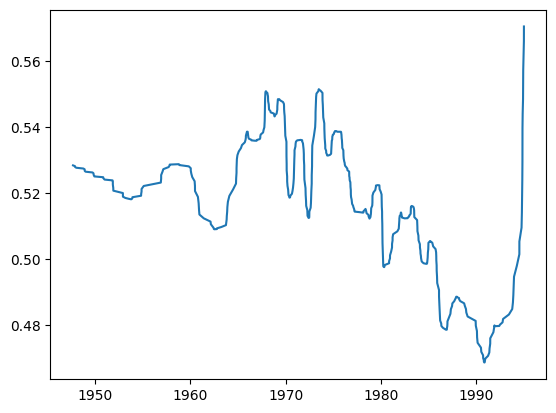

In [85]:
plt.plot(rd.date,rd.s)

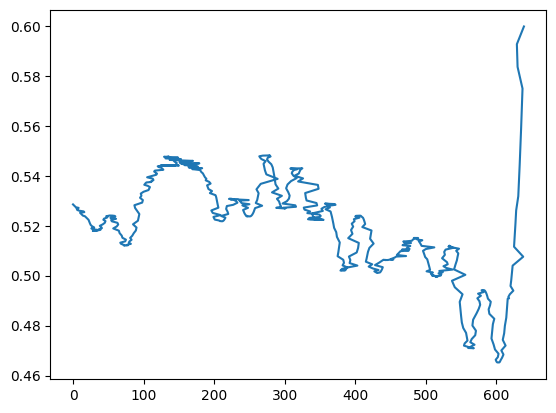

In [66]:
plt.plot(rd.sigma_afa)

In [86]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from numpy import inf

def mutual_information(theta, topn=None):
    """
    theta (np.array): numpy array with rows as document-topic mixtures:
    
    returns:
    R_ij: np.array of linkage scores as measured with mutual information
    """
    if topn:
        theta = np.where(np.argsort(np.argsort(theta)) >= theta.shape[1]-topn, theta, 0.0000000001)

    p_ij = theta[:,:,None] * theta[:,None,:]
    p_ij = p_ij.sum(axis=0) / p_ij.sum()
    pt_i = theta.sum(axis=0)
    pt_i = pt_i / pt_i.sum()
    R_ij = np.log2(p_ij / (np.outer(pt_i.ravel(), pt_i.ravel())))
    ptj_i = p_ij / pt_i
    Ri = (R_ij * ptj_i).sum(axis=0)
    M = (Ri * pt_i).sum(axis=0)  
    return R_ij, Ri, M

def flatten_mi_array(theta):
    m,n = theta.shape
    theta[:] = np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,theta)
    ta_ = theta.flatten()
    ix = np.array(list(np.ndindex(theta.shape)))
    na = np.column_stack((ix[:,0],ix[:,1],ta_))
    return pd.DataFrame(na).dropna()

In [87]:
distsn

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
nl.proc.sgd.d.194719480000420.1,0.108510,0.000507,0.000089,0.000163,0.000199,0.000232,0.000083,0.000101,0.000136,0.203330,...,0.000131,0.000058,0.000240,0.000462,0.000372,0.000292,0.000131,0.054223,0.000571,0.000080
nl.proc.sgd.d.194719480000420.1,0.000524,0.000689,0.000121,0.000221,0.000271,0.000316,0.000113,0.000137,0.000185,0.000810,...,0.000178,0.000079,0.000327,0.000627,0.000506,0.000397,0.000177,0.000219,0.000777,0.000109
nl.proc.sgd.d.194719480000420.1,0.015843,0.003399,0.000123,0.000225,0.000276,0.000322,0.000116,0.000140,0.000188,0.016280,...,0.000181,0.000080,0.000333,0.003336,0.000516,0.000404,0.000181,0.011007,0.000792,0.000111
nl.proc.sgd.d.194719480000420.1,0.030281,0.000560,0.000098,0.000180,0.000220,0.000256,0.000092,0.000111,0.000150,0.000658,...,0.000145,0.000064,0.000266,0.000510,0.000411,0.000322,0.000144,0.209168,0.000631,0.000089
nl.proc.sgd.d.194719480000421.2,0.000524,0.003094,0.000121,0.001401,0.005666,0.000316,0.000113,0.000137,0.000185,0.011426,...,0.000178,0.000079,0.001529,0.000628,0.002865,0.000397,0.001357,0.000219,0.000777,0.000109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nl.proc.sgd.d.199419950000332.5,0.010661,0.000600,0.000105,0.000192,0.000235,0.025437,0.000099,0.000119,0.000161,0.000705,...,0.000155,0.000069,0.000284,0.000546,0.000440,0.000345,0.000154,0.000191,0.000676,0.000095
nl.proc.sgd.d.199419950000332.5,0.000499,0.000657,0.000115,0.000211,0.000258,0.000301,0.000108,0.000131,0.000176,0.000772,...,0.000169,0.000075,0.000311,0.000598,0.000482,0.000378,0.000169,0.000209,0.000740,0.000104
nl.proc.sgd.d.199419950000332.5,0.005247,0.000696,0.000122,0.000223,0.000273,0.009754,0.000114,0.000138,0.000186,0.000818,...,0.000180,0.000080,0.000330,0.005020,0.000511,0.005118,0.000179,0.000221,0.000784,0.000110
nl.proc.sgd.d.199419950000332.5,0.000529,0.000696,0.000122,0.000223,0.000273,0.012900,0.000114,0.000138,0.000186,0.000817,...,0.000179,0.000079,0.000330,0.000633,0.000511,0.000400,0.000179,0.000221,0.000784,0.000110
